In [1]:
from include.road_process import Road
from include.cool_space import CoolSpace
from include.building import Building
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
directory_mac = "/Volumes/T7 Shield/TUD/Synthesis/cool_place/"
directory_win = "G:\\TUD\\Synthesis\\cool_place\\"

landuse_file = directory_win + "ams_landuse_top10NL.shp"
road_file = directory_win + "ams_roads_top10NL.shp"
building_file = directory_win + "ams_buildings_bagplus.shp"

coolSpace = CoolSpace(gpd.read_file(landuse_file))
road = Road(gpd.read_file(road_file))
building = Building(gpd.read_file(building_file))

In [3]:
road.create_attribute('typeweg', 'buffer')
road.create_buffer('buffer')
building.create_buffer(4)

Buffered geometry column created.
Buffered geometry column created.


In [11]:
road.data = road.data.set_geometry("buffered")
coolSpace.clip(coolSpace.data, road.data)

building.data = building.data.set_geometry("buffered")
coolSpace.data = coolSpace.data.set_geometry("clipped")
coolSpace.clip(coolSpace.data, building.data)

D:\Files\GitHub\shady_amsterdam\cool_place\include\cool_space.py:22: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:28992
Right CRS: None

  clipped = gpd.overlay(to_clip, clipper, how=how)
D:\Files\GitHub\shady_amsterdam\cool_place\include\cool_space.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 3948 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped = gpd.overlay(to_clip, clipper, how=how)
D:\Files\GitHub\shady_amsterdam\cool_place\include\cool_space.py:22: UserWarning: `keep_geom_type=True` in overlay resulted in 3948 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  clipped = gpd.overlay(to_clip, clipper, how=how)


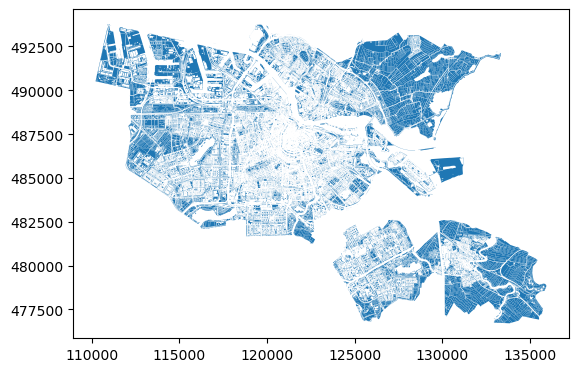

In [12]:
coolSpace.data["clipped"].plot()
plt.show()

In [13]:
coolSpace.data["clipped"].to_file(directory_win + "test.shp")
coolSpace.data["geometry"].to_file(directory_win + "test2.shp")